<a href="https://colab.research.google.com/github/weathon/3d2smile/blob/main/Test_SMILES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !wget http://file.weasoft.com/80k.csv -nv
# !wget http://file.weasoft.com/swin_transform_focalloss.pth -nv
# !wget http://file.weasoft.com/80k.zip
# !unzip -q 80k.zip
# !pip3 install torch_xla
# !pip3 install deepsmiles yacs tqdm
# !git clone https://github.com/suanfaxiaohuo/SwinOCSR.git
# !pip install focal_loss_torch wandb

In [3]:
# !wget http://file.weasoft.com/main.pb -nv

In [4]:
import torch, torchvision
import os
import numpy as np
import pylab
import pandas
import sys
from PIL import Image

In [5]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    HOME_DIR = "/content"
else:
    HOME_DIR = "/arc/burst/st-dushan20-1/"

In [6]:

# From the SwinOCSR
import sys
sys.path.append("/content/SwinOCSR/model/Swin-transformer-focalloss")
sys.path.append("./SwinOCSR/model/")

import sys
import os
import argparse
from tqdm import tqdm
import deepsmiles
from typing import Any, cast, Callable, List, Tuple, Union
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms

from pre_transformer import Transformer

In [7]:
# os.environ['PJRT_DEVICE'] = 'TPU' #That is why
import torch_xla
import torch_xla.core.xla_model as xm
# import torch_xla.runtime as xr
# device = xm.xla_device()
try:
  5/0
  import torch_xla
  import torch_xla.core.xla_model as xmc
  device = xm.xla_device()
except:
  if torch.cuda.is_available():
      device = torch.device('cuda:0')
  else:
      device = torch.device('cpu')

# Swin-OCSR Def

In [8]:
class FocalLossModelInference:
    """
    Inference Class
    """
    def __init__(self):
        # Load dictionary that maps tokens to integers
        word_map_path = './SwinOCSR/Data/500wan/500wan_shuffle_DeepSMILES_word_map'
        self.word_map = torch.load(word_map_path)
        self.inv_word_map = {v: k for k, v in self.word_map.items()}

        # Define device, load models and weights
        self.dev = "cuda" if torch.cuda.is_available() else "cpu"
        # self.args, config = self.get_inference_config()
        # self.encoder = build_model(config, tag=False)
        self.decoder = self.build_decoder()
        self.load_checkpoint("./swin_transform_focalloss.pth")
        self.decoder = self.decoder.to(self.dev).eval()
        # self.encoder = self.encoder.to(self.dev).eval()

    def load_checkpoint(self, checkpoint_path):
        """
        Load checkpoint and update encoder and decoder accordingly

        Args:
            checkpoint_path (str): path of checkpoint file
        """
        print(f"=====> {checkpoint_path} <=====")
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        # encoder_msg = self.encoder.load_state_dict(checkpoint['encoder'],
        #                                            strict=False)
        decoder_msg = self.decoder.load_state_dict(checkpoint['decoder'],
                                                   strict=False)
        # print(f"Encoder: {encoder_msg}")
        print(f"Decoder: {decoder_msg}")
        del checkpoint
        torch.cuda.empty_cache()

    def build_decoder(self):
        """
        This method builds the Transformer decoder and returns it
        """
        self.decoder_dim = 256  # dimension of decoder RNN
        self.ff_dim = 2048
        self.num_head = 8
        self.dropout = 0.1
        self.encoder_num_layer = 6
        self.decoder_num_layer = 6
        self.max_len = 277
        self.decoder_lr = 5e-4
        self.best_acc = 0.
        return Transformer(dim=self.decoder_dim,
                           ff_dim=self.ff_dim,
                           num_head=self.num_head,
                           encoder_num_layer=self.encoder_num_layer,
                           decoder_num_layer=self.decoder_num_layer,
                           vocab_size=len(self.word_map),
                           max_len=self.max_len,
                           drop_rate=self.dropout,
                           tag=False)
transformer_ = FocalLossModelInference()
transformer = transformer_.build_decoder().decoder

converter = deepsmiles.Converter(rings=True, branches=True)


def str_to_vector(s: str)->list:
  return [transformer_.word_map[i] for i in converter.encode(s)]


import pandas as pd
csv = pd.read_csv("./80k.csv")
cids = csv["cid"]
csv.columns


=====> ./swin_transform_focalloss.pth <=====
Decoder: <All keys matched successfully>


Index(['cid', 'cmpdname', 'cmpdsynonym', 'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'isosmiles', 'canonicalsmiles', 'inchikey', 'iupacname', 'exactmass',
       'monoisotopicmass', 'charge', 'covalentunitcnt', 'isotopeatomcnt',
       'totalatomstereocnt', 'definedatomstereocnt', 'undefinedatomstereocnt',
       'totalbondstereocnt', 'definedbondstereocnt', 'undefinedbondstereocnt',
       'pclidcnt', 'gpidcnt', 'gpfamilycnt', 'neighbortype', 'meshheadings',
       'annothits', 'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

# pre-processing

In [9]:
# prompt: Ys = {} invalid_cids = [] for i in cids.values: tmp = str_to_vector(csv[csv["cid"] == i]["canonicalsmiles"].values[0]) if not tmp == None: Ys[i] = tmp else: invalid_cids.append(i)  try to copy Ys.pkl from users drive if it exsits skip this and just load from Ys.pkl other wise run this and save Ys and invalid cids in Ys.pkl. Then copy this to users google drive

import pickle
try:
  with open(HOME_DIR + "/Ys.pkl", "rb") as f:
    Ys, invalid_cids = pickle.load(f)
except FileNotFoundError:
  Ys = {}
  invalid_cids = []
  for i in cids.values:
    tmp = str_to_vector(csv[csv["cid"] == i]["canonicalsmiles"].values[0])
    if not tmp == None:
      Ys[i] = tmp
    else:
      invalid_cids.append(i)
  with open(HOME_DIR + "/Ys.pkl", "wb") as f:
    pickle.dump([Ys, invalid_cids], f)


In [10]:
from focal_loss.focal_loss import FocalLoss
m = torch.nn.Softmax(dim=-1)
lf = FocalLoss(gamma=2, ignore_index=0)#torch.nn.CrossEntropyLoss(label_smoothing=0.1, reduction="none")
def loss_fn(pred, truth):
  pred = m(pred)
  l = lf(pred, truth)
  return l

def mask_acc(pred, truth):
    pred = torch.argmax(pred, -1)
    mask = truth != 0
    match_case = truth == pred
    return torch.sum(mask*match_case)/torch.sum(mask)

import pickle

BATCH_SIZE = 4
files = os.listdir(f"./rendered/")
files = [i for i in files if len(i)<=40]
import multiprocessing, threading
#https://stackoverflow.com/questions/48822463/how-to-use-pytorch-multiprocessing
from torch.multiprocessing import Process, Queue, Pool
import time
buffer = Queue(maxsize=10) #need maxsize=10, otherwise put will also block
start_index = 0
import cv2
def process_single(arg):
    # print(arg)
    _, start_index = arg
    index = start_index + _
    try:
      id = int(files[index].split("_")[0])
    except:
      return
    img = np.array(Image.open(f"{HOME_DIR}/rendered/{files[index]}")) #cannot read image? quota reached?
    return img, [77] + Ys[id], Ys[id] + [78]

images_warehouse = []
index = 0
import time
t0 = time.time()
import os, psutil
process = psutil.Process()


# reset

In [11]:
import gc

In [65]:

# https://stackoverflow.com/questions/70508960/how-to-free-gpu-memory-in-pytorch

try:
  model.cpu()
  gen.cpu()
  del model, gen
  gc.collect()
  torch.cuda.empty_cache()
except:
  pass
example_in = Image.open("./rendered/6912034_0.jpg")
example_out = csv[csv["cid"]==6912034]["canonicalsmiles"].values[0]

# In[15]:
example_out = str_to_vector(example_out)
import numpy as np

eff = torchvision.models.efficientnet_v2_l(weights='DEFAULT')
mynet = eff.features
class ImageEncoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.eff = mynet.to(device)
    self.projection = torch.nn.Linear(1280,256).to(device)
  def forward(self, images):
    features = self.eff(images)
    features = torch.flatten(features, start_dim=2, end_dim=3)
    features = torch.permute(features, (0, 2, 1))
    return self.projection(features)



encoder = ImageEncoder()

for p in transformer.parameters():
  p.requires_grad = False


# In[45]:
# from another paper
def pad_pack(sequences):
    maxlen = max(map(len, sequences))
    batch = torch.LongTensor(len(sequences),maxlen).fill_(0)
    for i,x in enumerate(sequences):
        batch[i,:len(x)] = torch.LongTensor(x)
    return batch, maxlen

# https://github.com/suanfaxiaohuo/SwinOCSR/blob/main/model/Swin-transformer-focalloss/pre_transformer.py#L95
def triangle_mask(size):
    mask = 1- np.triu(np.ones((1, size, size)),k=1).astype('uint8')
    mask = torch.autograd.Variable(torch.from_numpy(mask))
    return mask


class Image2SMILES(torch.nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, image, text_in, xmask):
    image_feature = self.encoder(image)
    out = self.decoder(text_in, image_feature, x_mask=xmask)
    return out

# In[46]:

def softmax(x):
        t = np.exp(x)
        return t/np.sum(t)

softmax_1 = torch.nn.Softmax(dim=-1)
torch_softmax = torch.nn.Softmax()
class SMILESGenerator(torch.nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, image, text_in_, max_len, beam): #just changed beam=1 and it runs so beam cannot be random number???  yeah it has to been factor of 676, which is 2 2 13 13 but original paper did not use beam search
    image_feature = self.encoder(image)
    top_n = list([list(i) for i in torch.tensor(text_in_).repeat(beam,1).detach().cpu().numpy()])
    # print(top_n)
    image_feature = image_feature.repeat_interleave(beam, dim=0)#.repeat_interleave(beam)
    for i in range(max_len):
      if beam == 1:
        padded_text, l = pad_pack(top_n)
        padded_text = padded_text.to(device)
        out = self.decoder(padded_text, image_feature, x_mask=triangle_mask(l).to(device))
        out = out[0,-1,:]
        next = torch.argmax(out)
        top_n[0] += [next.detach().cpu().item()]
        if next == 78:
          return top_n
        continue
      padded_text, l = pad_pack(top_n)
      padded_text = padded_text.to(device)
      out = self.decoder(padded_text, image_feature, x_mask=triangle_mask(l).to(device))
      out = out[:,-1,:]
      next = torch.topk(torch.flatten(out), beam)
      indices2d = np.array(np.unravel_index(next.indices.cpu().numpy(), out.shape)).T
      new_top_n = []
      count = 0
      for j in indices2d:
        beam_number = j[0]
        char = j[1]
        if char == 78:
          count += 1
          new_top_n.append(top_n[beam_number])
        else:
          new_top_n.append(top_n[beam_number] + [char])
      if count == beam:
        return new_top_n
      top_n = new_top_n
    return top_n


model = Image2SMILES(encoder, transformer)
model.load_state_dict(torch.load("./main.pb", map_location=device))
gen = SMILESGenerator(model.encoder, model.decoder)
for param in model.parameters():
    param.requires_grad = True

for param in gen.parameters():
    param.requires_grad = True

for param in model.decoder.parameters():
    param.requires_grad = False

model = model.to(device)
gen = gen.to(device)


def softmax(x):
  t = np.exp(x)
  return t/np.sum(t)


In [45]:
torch.tensor([[77]]).repeat_interleave(2, dim=0)

tensor([[77],
        [77]])

# -

In [13]:
reversed_word_map = {}
for i in transformer_.word_map.keys():
 reversed_word_map[transformer_.word_map[i]] = i

In [40]:
import wandb
print("Started")

optimizer = torch.optim.AdamW(
   model.parameters(),
   lr=0.0003)


scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99987)


loss_list = []
model.to(device)


def getitem(i):
 imgs = []
 ti = []
 to = []
 for i in range(i, i+BATCH_SIZE):
    index = i
    try:
      id = int(files[index].split("_")[0])
    except:
      return
    try:
     img = np.array(Image.open(f"./rendered/{files[index]}")) #cannot read image? quota reached?
     imgs.append(img)
     ti.append([77] + Ys[id])
     to.append(Ys[id] + [78])
    except:
     pass
 return torch.tensor(np.array(imgs), dtype=torch.float32), ti, to

Test = True


Started


In [15]:
wandb.login()

wandb: Currently logged in as: wguo6358 (3dsmile). Use `wandb login --relogin` to force relogin


True

In [ ]:
if Test:
  model.train(False)
  gen.train(False)
  running_loss = 0
  last_loss = 0
  tf_count = 0
  bs_count = 0
  ans = {}
  for beam_count in [1, 2, 3, 4, 5, 6, 7, 8]:
    ans[beam_count] = 0
    for i in range(0, 1000):
      start_index = i * BATCH_SIZE
      Xs_img = []
      Xs_text = []
      y = []

      image, text_in, text_out = getitem(start_index)
      image = image.to(device)
      text_out = pad_pack(text_out)[0].to(device)
      padded_x = pad_pack(text_in)
      xmask = triangle_mask(padded_x[1]).to(device)
      image = torch.permute(image, (0, 3, 1, 2))
      text_in = padded_x[0].to(device)
      outputs = model(image, text_in, xmask)[0].cpu().detach().numpy()
      # tf = "".join([reversed_word_map[np.argmax(i)] for i in outputs]).replace("<end>","").replace("<start>","").replace("<pad>","")
      bs = "".join([reversed_word_map[i] for i in gen(image[:1,:,:,:], [[77]], len(text_in[0]), beam=beam_count)[0]]).replace("<end>","").replace("<start>","").replace("<pad>","")
      #  try textin[:,:-1] then -3 then 1 and it work,:0s and now i got why the beam used to need to be factor that is because image side is that i need repeat image side
      correct = "".join([reversed_word_map[i] for i in text_out[0].detach().cpu().numpy()]).replace("<end>","").replace("<start>","").replace("<pad>","")
      # if tf == correct:
      #   tf_count += 1
      if bs == correct:
        bs_count += 1
        ans[beam_count] += 1

      # print(tf)
      # print(bs)
      # print(correct) #print le cai fa xian you <end>
      # print("Teacher forcing output:\t\t", "".join([reversed_word_map[np.argmax(i)] for i in outputs]))
      # print("Token by Token Output:\t\t", "".join([reversed_word_map[i] for i in gen(image, [[77]], len(text_in[0]))[0]]))
      # print("Correct output:\t\t\t", "".join([reversed_word_map[i] for i in text_out[0].detach().cpu().numpy()]))


In [25]:
# haihao haibaoluzheruntim just ntoice that duzie i say if there is batch norm in image encoder wait what is the batch size there then relized there are 4 images
print("".join([reversed_word_map[i] for i in gen(image[:1,:,:,:], [[77]], len(text_in[0]), beam=1)[0]]).replace("<end>","").replace("<start>","").replace("<pad>",""))
print("".join([reversed_word_map[i] for i in gen(image, [[77]]*4, len(text_in[0]), beam=1)[0]]).replace("<end>","").replace("<start>","").replace("<pad>",""))
print("".join([reversed_word_map[i] for i in text_out[0].detach().cpu().numpy()]).replace("<end>","").replace("<start>","").replace("<pad>",""))

[[77]]
CCNC=S)N
[[77], [77], [77], [77]]
CCNC=S)N
CCNC=S)N


In [24]:
image[:1,:,:,:].shape

torch.Size([3, 400, 400])

In [ ]:
for epoch in range(30):
  model.train(True)

  for i in range(10, len(files)//BATCH_SIZE):
    image, text_in, text_out = getitem(start_index)

    image = image.to(device) #mutli process cannot use cuda so moved here
    image = torch.permute(image, (0, 3, 1, 2))
    text_out = pad_pack(text_out)[0].to(device)
    padded_x = pad_pack(text_in)

    xmask = triangle_mask(padded_x[1]).to(device)
    text_in = padded_x[0].to(device)

    optimizer.zero_grad()
    outputs = model(image, text_in, xmask)
    loss = loss_fn(outputs, text_out)
    loss.backward()

    optimizer.step()

    running_loss += loss.item()

    if i%100==99:
        wandb.log({"loss": running_loss/100, "acc":mask_acc(outputs.detach(), text_out), "lr": optimizer.param_groups[0]['lr']})
        running_loss = 0.
    if i%10 == 9:
        scheduler.step()

    if i == 10:
        model.train(False)
        loss_ = 0
        acc_ = 0
        for ii in range(0,10):
            tf = "".join([reversed_word_map[np.argmax(i)] for i in outputs]).replace("<end>","").replace("<start>","").replace("<pad>","")
            bs = "".join([reversed_word_map[i] for i in gen(image, text_in[:,:1], len(text_in[0]), beam=1)[0]]).replace("<end>","").replace("<start>","").replace("<pad>","")
            correct = "".join([reversed_word_map[i] for i in text_out[0].detach().cpu().numpy()]).replace("<end>","").replace("<start>","").replace("<pad>","")
            print(f"tf:\t{tf}\n bs:\t{bs}\n correct:\t{correct}\n")

            Xs_img, text_in, text_out = getitem(ii * BATCH_SIZE)
            image = Xs_img.to(device)
            image = torch.permute(image, (0, 3, 1, 2))
            text_out = pad_pack(text_out)[0].to(device)
            padded_x = pad_pack(text_in)
            xmask = triangle_mask(padded_x[1]).to(device)
            text_in = padded_x[0].to(device)
            text_in = torch.permute(text_in, (1,0))
            outputs = model(image, text_in, xmask)
            loss = loss_fn(outputs, text_out)
            loss_ += loss
            acc_ += mask_acc(outputs.detach(), text_out)
        wandb.log({"val_loss": loss/10, "val_acc":acc_/10})
        model.train(True)

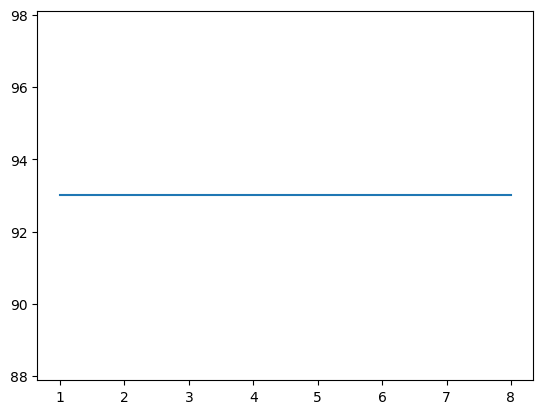

In [67]:
import pylab
keys = ans.keys()
values = ans.values()
pylab.plot(keys, values)
pylab.show()